# MFS demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('..','..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import PolarisationFrame
from arl.visibility.base import create_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, smooth_image, \
    calculate_image_frequency_moments, calculate_image_from_frequency_moments
from arl.image.deconvolution import deconvolve_cube, restore_cube
from arl.image.iterators import  image_raster_iter
from arl.image.solvers import solve_image
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, \
    create_low_test_image_from_gleam, create_low_test_beam
from arl.imaging import *
from arl.imaging.weighting import weight_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW configuration

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [2]:
config = 'core'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=5 * 2048
    padding = 1
    context='2d'

else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=512
    padding = 2
    context='2d'
    
oversampling = 32

nchan = 7
frequency = numpy.linspace(0.8e8, 1.2e8, nchan)
centre_frequency = numpy.array([numpy.average(frequency)])
channel_bandwidth=numpy.array(nchan * [frequency[1]-frequency[0]])
total_bandwidth = numpy.array([numpy.sum(channel_bandwidth)])

times = numpy.linspace(-3, +3, 5) * numpy.pi / 12.0
log.info('Observing times %s' % (times))
log.info("Observing frequencies %s Hz" % (frequency))
log.info("Channel bandwidths %s Hz" % (channel_bandwidth))
log.info("Centre frequency %s Hz" % (centre_frequency))
log.info("Cellsize = %.6f radians" % (cellsize))

Observing times [-0.78539816 -0.39269908  0.          0.39269908  0.78539816]


Observing frequencies [  8.00000000e+07   8.66666667e+07   9.33333333e+07   1.00000000e+08
   1.06666667e+08   1.13333333e+08   1.20000000e+08] Hz


Channel bandwidths [ 6666666.66666667  6666666.66666667  6666666.66666667  6666666.66666667
  6666666.66666667  6666666.66666667  6666666.66666667] Hz


Centre frequency [  1.00000000e+08] Hz


Cellsize = 0.001000 radians


In [13]:
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 479325 rows, 0.050 GB


Plot the synthesized uv coverage

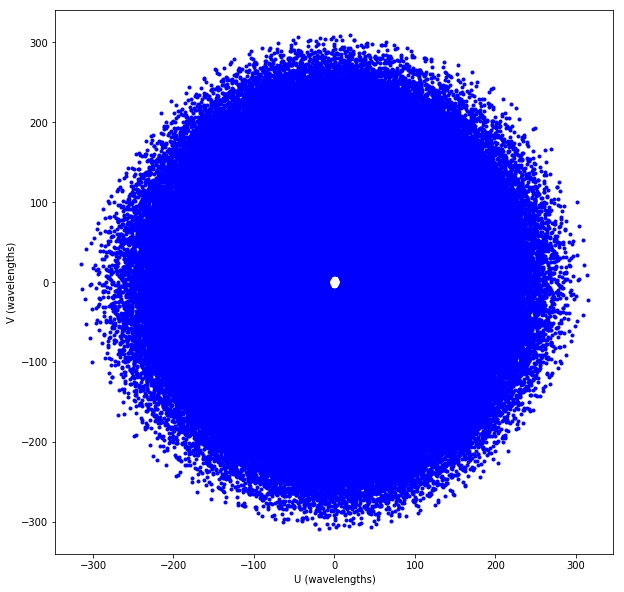

In [14]:
plt.clf()
plt.plot(vt.uvw[:,0],   vt.uvw[:,1], '.', color='b')
plt.plot(-vt.uvw[:,0], -vt.uvw[:,1], '.', color='b')
plt.xlabel("U (wavelengths)")
plt.ylabel("V (wavelengths)")
plt.show()

Make a test image

In [15]:
model_centrechannel = create_low_test_image_from_gleam(npixel=npixel, 
                                                       frequency=centre_frequency, 
                                                       channel_bandwidth=total_bandwidth, 
                                                       cellsize=cellsize, 
                                                       phasecentre=phasecentre, applybeam=True)
export_image_to_fits(model_centrechannel, '%s/imaging-mfs-model_centre_channel.fits' % 
                     (results_dir))

create_low_test_image_from_gleam: 16175 sources inside the image


create_low_test_image_from_gleam: Average flux per channel in image = 5539.212


import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)

import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000


create_low_test_beam: primary beam is defined at 100.000 MHz


In [16]:
model_multichannel = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency, 
                                                      channel_bandwidth=channel_bandwidth, 
                                                      cellsize=cellsize, 
                                                      phasecentre=phasecentre, applybeam=True)

create_low_test_image_from_gleam: 16175 sources inside the image


create_low_test_image_from_gleam: Average flux per channel in image = 5652.509


import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)


import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000


create_low_test_beam: primary beam is defined at 100.000 MHz


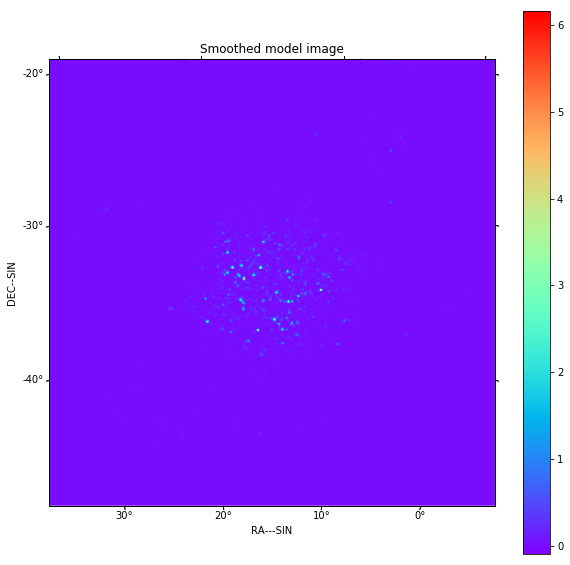

In [9]:
cmodel = smooth_image(model_multichannel)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()
export_image_to_fits(cmodel, '%s/imaging-mfs-cmodel.fits' % (results_dir))

In [10]:
export_image_to_fits(model_multichannel, '%s/imaging-mfs-multi_channel.fits' % (results_dir))
moment_cube = calculate_image_frequency_moments(model_multichannel,nmoments=3)
export_image_to_fits(moment_cube, '%s/imaging-mfs-moment_cube.fits' % (results_dir))

calculate_image_frequency_moments: Reference frequency = 100000000.000 (MHz)


In [11]:
reconstructed_cube = calculate_image_from_frequency_moments(model_multichannel, moment_cube)
export_image_to_fits(reconstructed_cube, '%s/imaging-mfs-reconstructed_cube.fits' % 
                     (results_dir))

calculate_image_from_frequency_moments: Reference frequency = 100000000.000 (MHz)


predict_with_iterators: Processing chunks


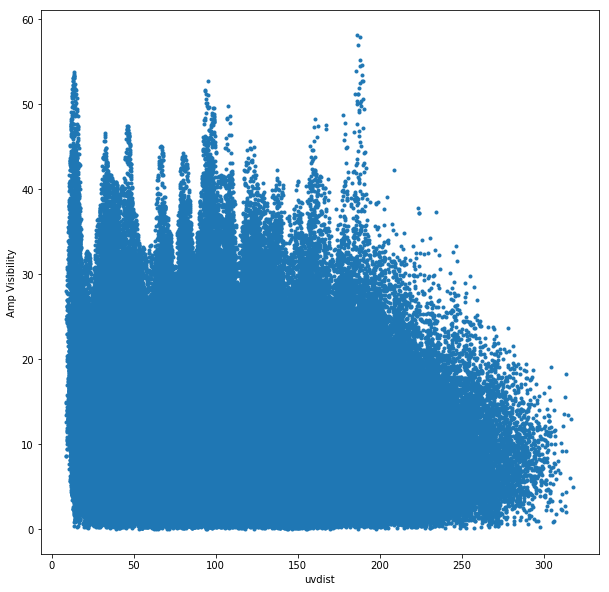

In [17]:
vt.data['vis'] *= 0.0
vt = predict_function(vt, model_multichannel, context='2d')

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Weight the data

weight_gridding: Performing uniform weighting


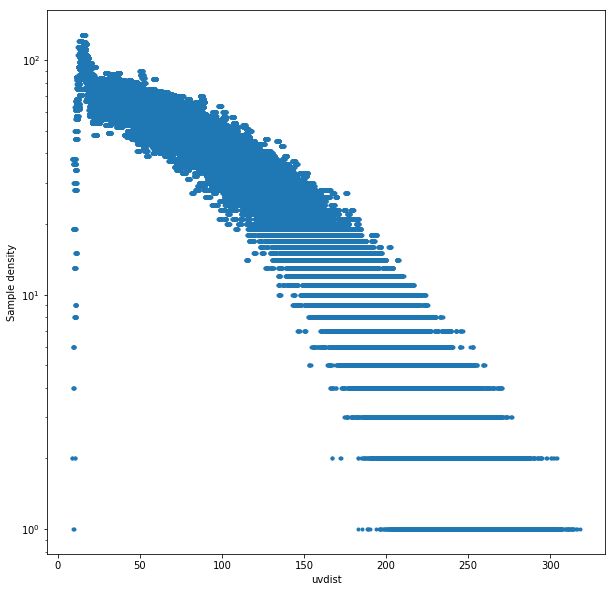

In [18]:
vt, density, densitygrid = weight_visibility(vt, model_centrechannel)
plt.clf()
plt.semilogy(uvdist, density, '.')
plt.xlabel('uvdist')
plt.ylabel('Sample density')
plt.show()
density = None
densitygrid = None

Make the dirty image and point spread function

Max, min in dirty image = 6.101372, -1.176435, sumwt = [[ 0.0074612 ]
 [ 0.01949468]
 [ 0.01344143]
 [ 0.01722248]
 [ 0.02214951]
 [ 0.02766401]
 [ 0.        ]]
Max, min in PSF         = 0.999924, -0.228077, sumwt = [[ 0.0074612 ]
 [ 0.01949468]
 [ 0.01344143]
 [ 0.01722248]
 [ 0.02214951]
 [ 0.02766401]
 [ 0.        ]]


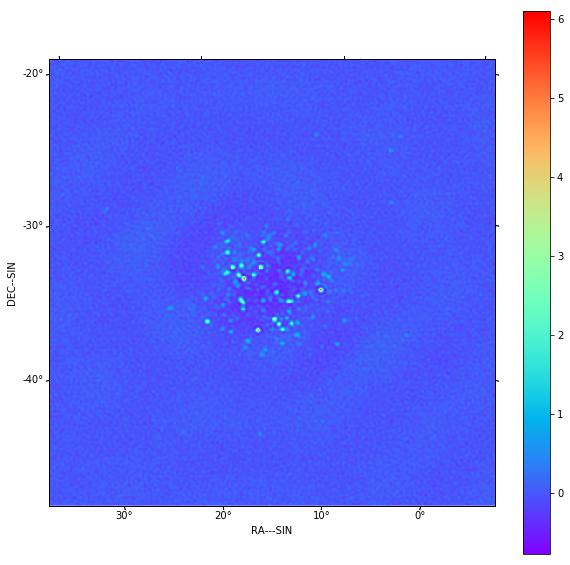

In [20]:
dirty, sumwt = invert_function(vt, model_multichannel, context='2d', padding=1)
show_image(dirty)
psf, sumwt = invert_function(vt, model_multichannel, context='2d', dopsf=True, padding=1)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %s" % 
      (dirty.data.max(), dirty.data.min(), sumwt))
print("Max, min in PSF         = %.6f, %.6f, sumwt = %s" % 
      (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-mfs-dirty.fits' % (results_dir))
export_image_to_fits(psf, '%s/imaging-mfs-psf.fits' % (results_dir))

deconvolve_cube: Multi-scale multi-frequency clean of each polarisation separately


calculate_image_frequency_moments: Reference frequency = 100000000.000 (MHz)


calculate_image_frequency_moments: Reference frequency = 100000000.000 (MHz)


deconvolve_cube: Processing pol 0


msmfsclean: Peak of PSF = 5.99953904296 at (0, 256, 256)


msmfsclean: Peak of Dirty = 27.7579603461 at (0, 260, 223)


msmfsclean: Moment-moment coupling matrix[scale 0] =
 [[  1.00000000e+00  -3.33333144e-02   1.40740746e-02]
 [ -3.33333144e-02   1.40740746e-02  -1.33333307e-03]
 [  1.40740746e-02  -1.33333307e-03   3.78600815e-04]]


msmfsclean: Moment-moment coupling matrix[scale 1] =
 [[  8.64152012e-01  -3.37671027e-02   1.25327996e-02]
 [ -3.37671027e-02   1.25327996e-02  -1.28388950e-03]
 [  1.25327996e-02  -1.28388950e-03   3.44142009e-04]]


msmfsclean: Moment-moment coupling matrix[scale 2] =
 [[  2.01387913e-01  -1.87291097e-02   3.96178267e-03]
 [ -1.87291097e-02   3.96178267e-03  -6.15404362e-04]
 [  3.96178267e-03  -6.15404362e-04   1.26503660e-04]]


msmfsclean: Moment-moment coupling matrix[scale 3] =
 [[  2.31709243e-02  -2.66578754e-03   5.30984172e-04]
 [ -2.66578754e-03   5.30984172e-04  -8.97759112e-05]
 [  5.30984172e-04  -8.97759112e-05   1.79354099e-05]]


msmfsclean: Max abs in dirty Image = 4.626682


msmfsclean: Start of minor cycle


msmfsclean: This minor cycle will stop at 1000 iterations or peak < 0.01


msmfsclean: Minor cycle 0, peak [ 4.90404555 -4.78264681 -7.65279005] at [260, 223, 1]


msmfsclean: Minor cycle 100, peak [ 0.35216127 -0.52943929  4.2803945 ] at [260, 223, 0]


msmfsclean: Minor cycle 200, peak [ 0.25372935 -0.04338086  0.04576908] at [268, 277, 1]


msmfsclean: Minor cycle 300, peak [ 0.15491785 -0.64162819  0.22922329] at [274, 193, 1]


msmfsclean: Minor cycle 400, peak [ 0.1227534  -0.27484292 -0.59151363] at [266, 322, 0]


msmfsclean: Minor cycle 500, peak [ 0.08807357 -0.06896002  1.65873669] at [239, 221, 0]


msmfsclean: Minor cycle 600, peak [ 0.06656196 -0.4629964   1.44165473] at [224, 319, 0]


msmfsclean: Minor cycle 700, peak [-0.10558625  0.54435406  5.30083176] at [511, 298, 0]


msmfsclean: Minor cycle 800, peak [ 0.05560232 -0.1424795   1.1959083 ] at [234, 206, 0]


msmfsclean: Minor cycle 900, peak [ 0.05376971 -0.25920182  0.58970155] at [194, 257, 0]


msmfsclean: End of minor cycles


msmfsclean: Scale counts [681 254  62   3]


msmfsclean: Scale flux [  56.66669733  108.49610179   33.17271066    1.46980628]


deconvolve_cube: calculating spectral cubes


calculate_image_from_frequency_moments: Reference frequency = 100000000.000 (MHz)


calculate_image_from_frequency_moments: Reference frequency = 100000000.000 (MHz)


restore_cube: psfwidth = Parameter('y_stddev', value=1.640790133967771)


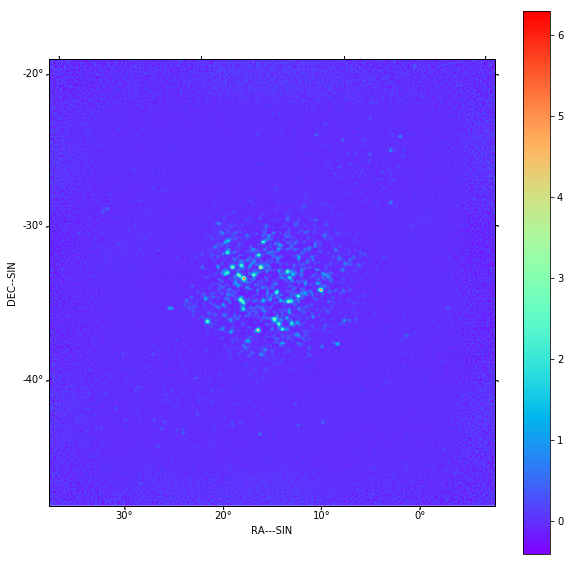

In [21]:
comp, residual = deconvolve_cube(dirty, psf, niter=1000, gain=0.7, algorithm='msmfsclean',
                scales=[0, 3, 10, 30], threshold=0.01, fractional_threshold=0.001, nmoments=3)
export_image_to_fits(comp, '%s/imaging-mfs-comp.fits' % (results_dir))
clean = restore_cube(model=comp, psf=psf, residual=residual)
export_image_to_fits(residual, '%s/imaging-mfs-residual.fits' % (results_dir))
export_image_to_fits(clean, '%s/imaging-mfs-clean.fits' % (results_dir))
show_image(clean)
plt.show()

Predict the visibility of the model

In [25]:
vtmodel = create_visibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_function(vtmodel, comp, context='2d')

create_visibility: 479325 rows, 0.050 GB


predict_with_iterators: Processing chunks


Now we will plot the original visibility and the residual visibility.

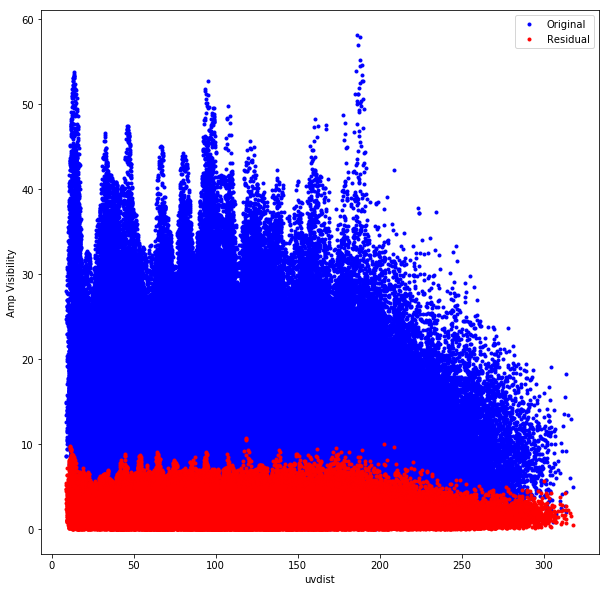

In [25]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.', color='b', label='Original')
plt.plot(uvdist, numpy.abs(vt.data['vis']-vtmodel.data['vis']), '.', color='r', 
         label='Residual')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()